In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from utils import *
from model import SegmentationModel
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 88em; }</style>"))

In [2]:
# Create a mapping from class ID to RGB color value. Required for visualization.
id2color = {
    0: (0, 0, 0),    # background pixel
    1: (0, 0, 255),  # Stomach
    2: (0, 255, 0),  # Small Bowel
    3: (255, 0, 0),  # large Bowel
}
 
print("Number of classes", DatasetConfig.NUM_CLASSES)
 
# Reverse id2color mapping.
# Used for converting RGB mask to a single channel (grayscale) representation.
rev_id2color = {value: key for key, value in id2color.items()}

Number of classes 4


In [3]:
data_module = SegmentationDataModule(
                num_classes=DatasetConfig.NUM_CLASSES,
                img_size=DatasetConfig.IMAGE_SIZE,
                ds_mean=DatasetConfig.MEAN,
                ds_std=DatasetConfig.STD,
                batch_size=InferenceConfig.BATCH_SIZE,
                num_workers=12,
                shuffle_validation=True,)
 
data_module.prepare_data()

# Create training & validation dataset.
data_module.setup()
 
train_loader, valid_loader = data_module.train_dataloader(), data_module.val_dataloader()

In [4]:
def num_to_rgb(num_arr, color_map=id2color):
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2] + (3,))
 
    for k in color_map.keys():
        output[single_layer == k] = color_map[k]
 
    # return a floating point array in range [0.0, 1.0]
    return np.float32(output) / 255.0

def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.
 
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
 
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    return np.clip(image, 0.0, 1.0)

def display_image_and_mask(*, images, masks, color_map=id2color):
    title = ["GT Image", "Color Mask", "Overlayed Mask"]
 
    for idx in range(images.shape[0]):
        image = images[idx]
        grayscale_gt_mask = masks[idx]
 
        fig = plt.figure(figsize=(15, 4))
 
        # Create RGB segmentation map from grayscale segmentation map.
        rgb_gt_mask = num_to_rgb(grayscale_gt_mask, color_map=color_map)
 
        # Create the overlayed image.
        overlayed_image = image_overlay(image, rgb_gt_mask)
 
        plt.subplot(1, 3, 1)
        plt.title(title[0])
        plt.imshow(image)
        plt.axis("off")
 
        plt.subplot(1, 3, 2)
        plt.title(title[1])
        plt.imshow(rgb_gt_mask)
        plt.axis("off")
 
        plt.imshow(rgb_gt_mask)
        plt.subplot(1, 3, 3)
        plt.title(title[2])
        plt.imshow(overlayed_image)
        plt.axis("off")
 
        plt.tight_layout()
        plt.show()
 
    return

def denormalize(tensors, *, mean, std):
    for c in range(3):#CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])
 
    return torch.clamp(tensors, min=0.0, max=1.0)

## Display sample images from validation dataset

batch_images shape: (10, 288, 288, 3)
batch_masks shape:  (10, 288, 288)


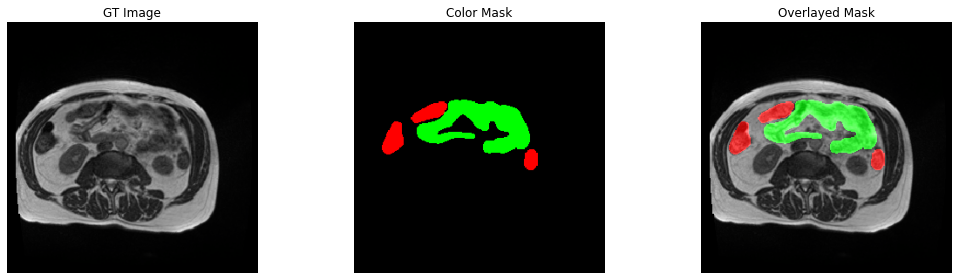

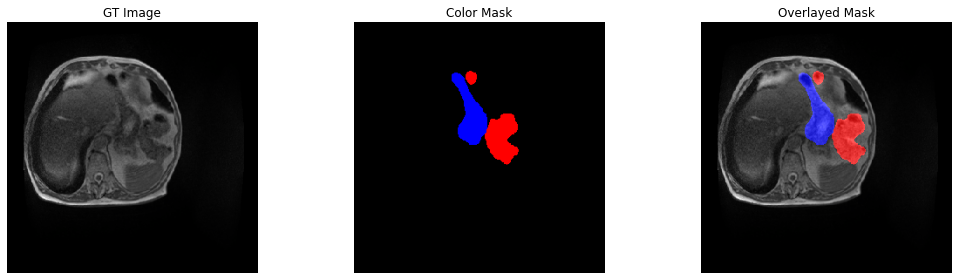

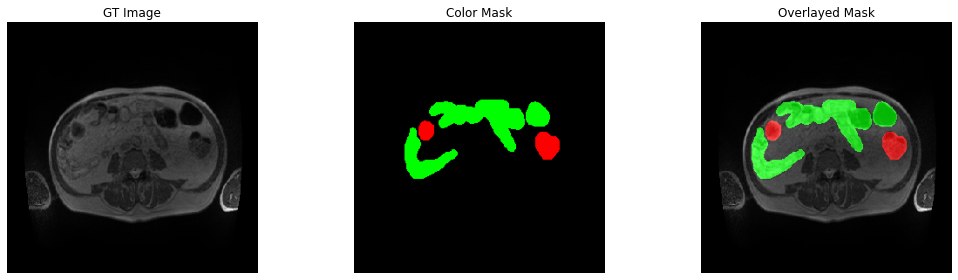

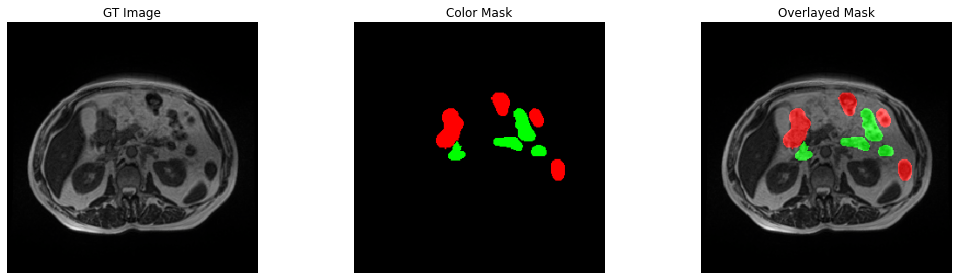

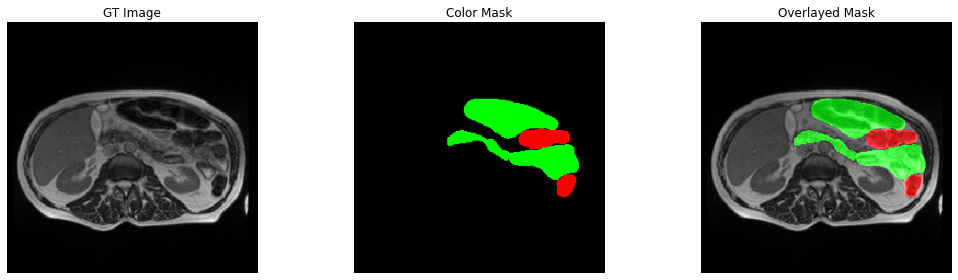

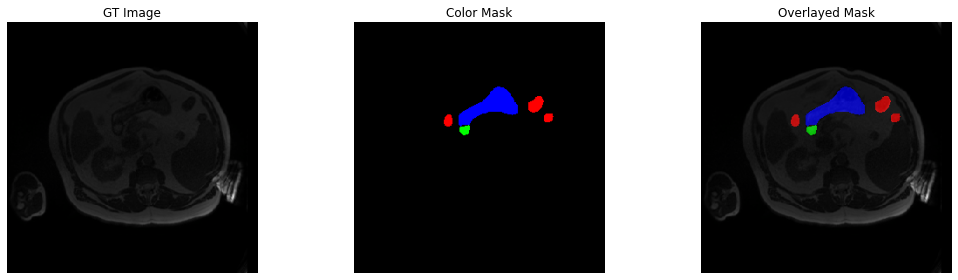

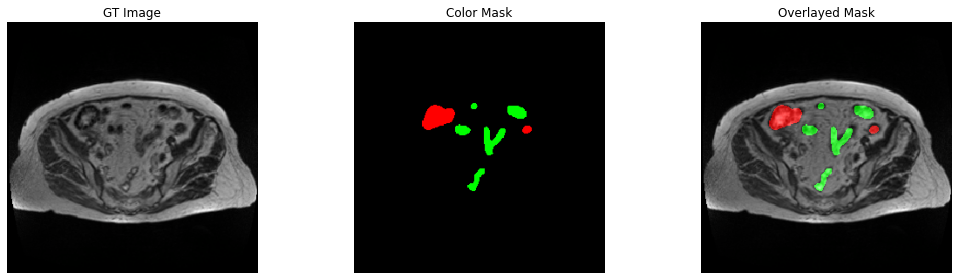

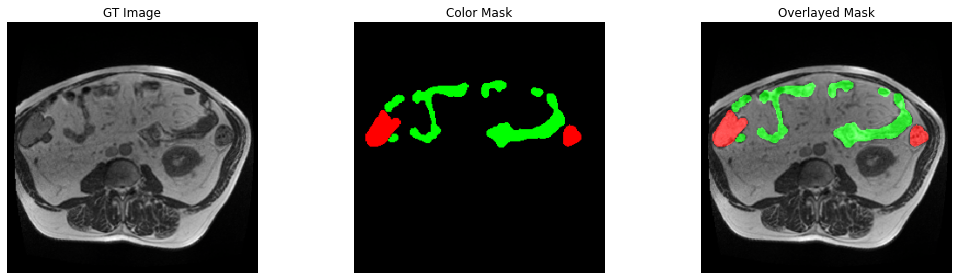

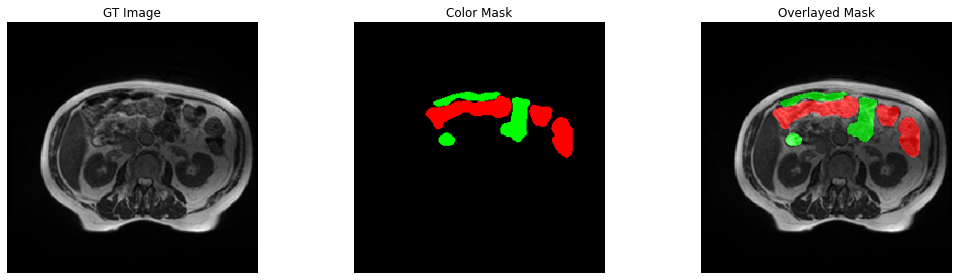

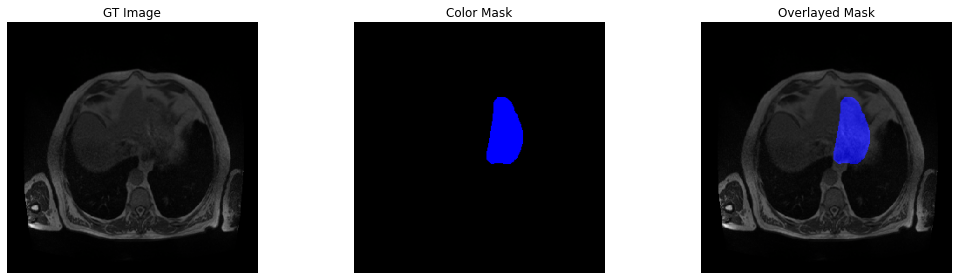

In [5]:
for batch_images, batch_masks in valid_loader:
 
    batch_images = denormalize(batch_images, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
    batch_masks  = batch_masks.numpy()
 
    print("batch_images shape:", batch_images.shape)
    print("batch_masks shape: ", batch_masks.shape)
     
    display_image_and_mask(images=batch_images, masks=batch_masks)
 
    break

## Display inference results from validation dataset

In [6]:
@torch.inference_mode()
def inference(model, loader, img_size, device="cpu"):
    num_batches_to_process = InferenceConfig.NUM_BATCHES
 
    for idx, (batch_img, batch_mask) in enumerate(loader):
        predictions = model(batch_img.to(device))
 
        pred_all = predictions.argmax(dim=1).cpu().numpy()
 
        batch_img = denormalize(batch_img.cpu(), mean=DatasetConfig.MEAN, std=DatasetConfig.STD)
        batch_img = batch_img.permute(0, 2, 3, 1).numpy()
 
        if idx == num_batches_to_process:
            break
 
        for i in range(0, len(batch_img)):
            fig = plt.figure(figsize=(20, 8))
 
            # Display the original image.
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text("MRI scan")
            plt.axis("off")
 
            # Display the ground truth mask.
            true_mask_rgb = num_to_rgb(batch_mask[i], color_map=id2color)
            ax2 = fig.add_subplot(1, 4, 2)
            ax2.set_title("Ground truth")
            ax2.imshow(true_mask_rgb)
            plt.axis("off")
 
            # Display the predicted segmentation mask.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color)
            ax3 = fig.add_subplot(1, 4, 3)
            ax3.set_title("Prediction")
            ax3.imshow(pred_mask_rgb)
            plt.axis("off")
 
            # Display the predicted segmentation mask overlayed on the original image.
            overlayed_image = image_overlay(batch_img[i], pred_mask_rgb)
            ax4 = fig.add_subplot(1, 4, 4)
            ax4.set_title("Overlayed image")
            ax4.imshow(overlayed_image)
            plt.axis("off")
            plt.show()

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-convnext-large and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([4, 512, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


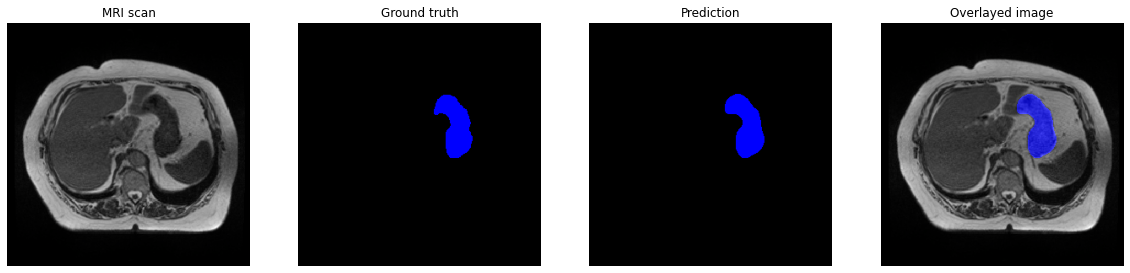

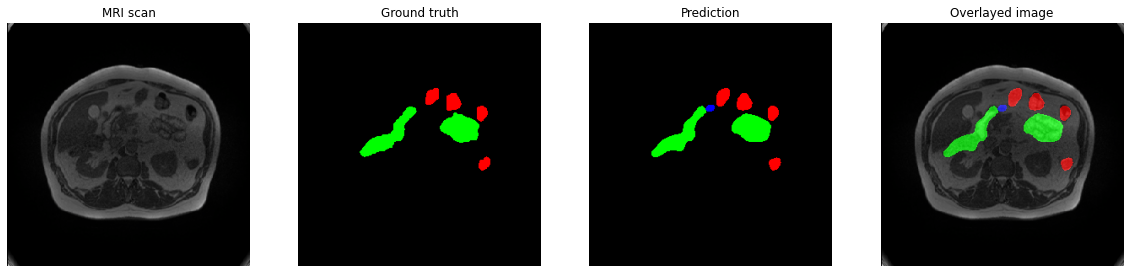

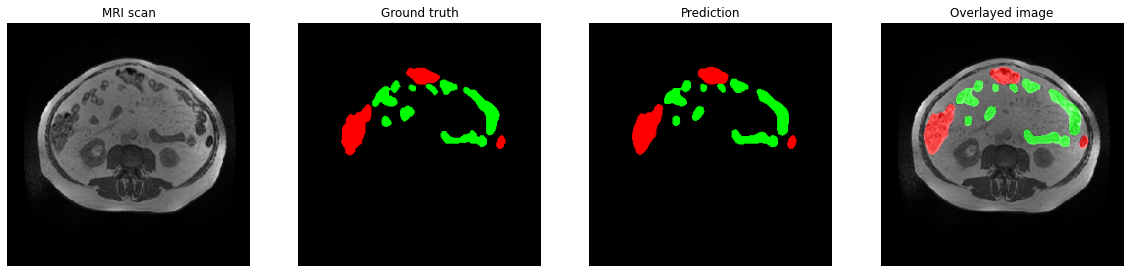

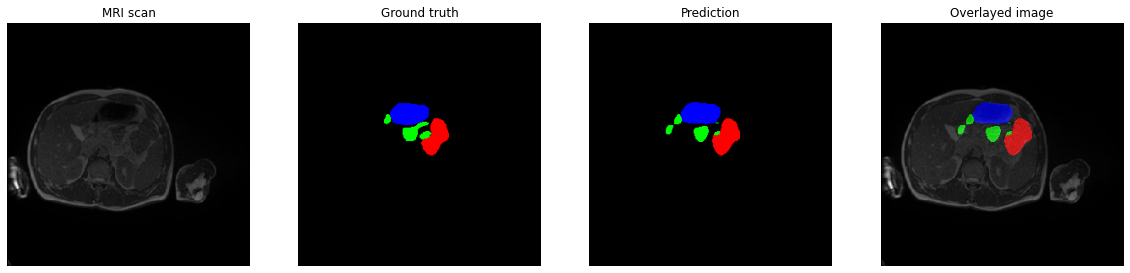

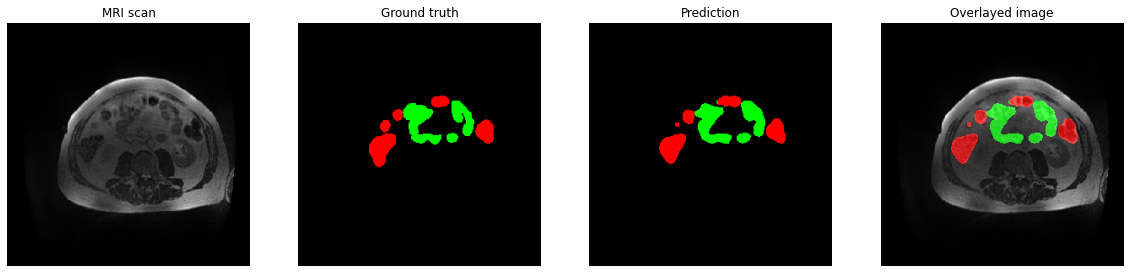

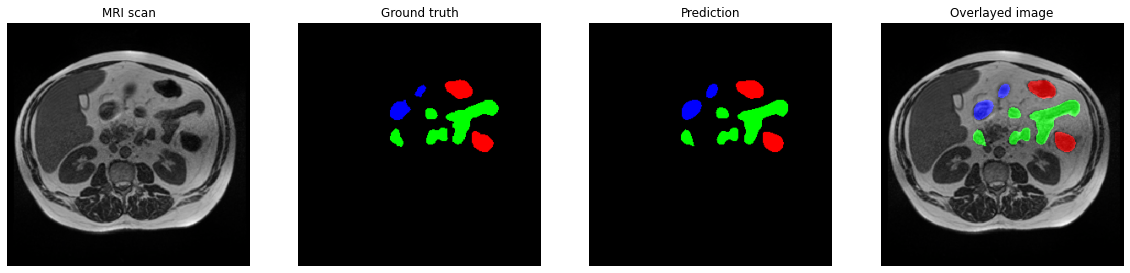

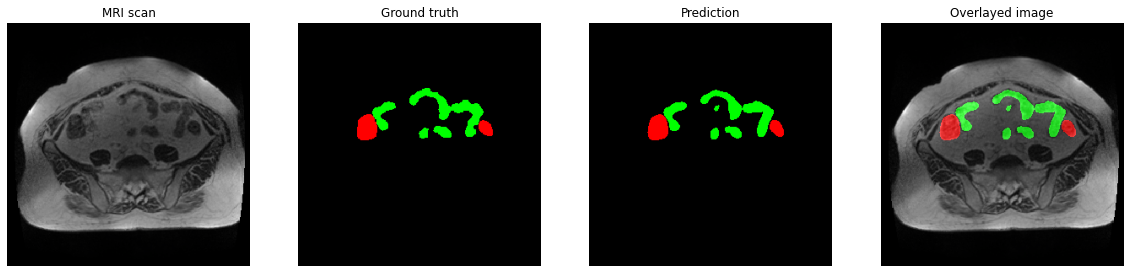

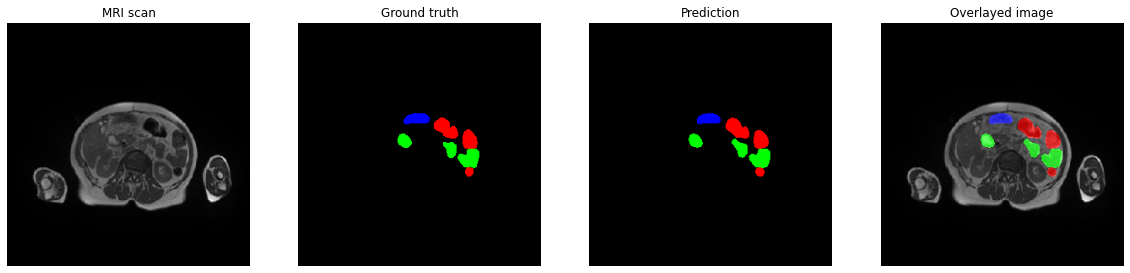

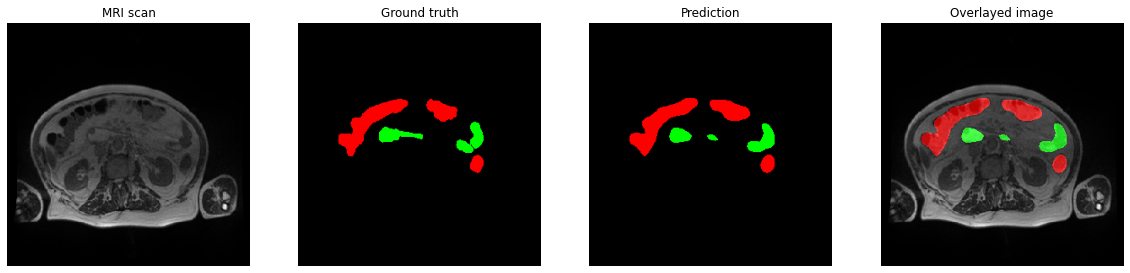

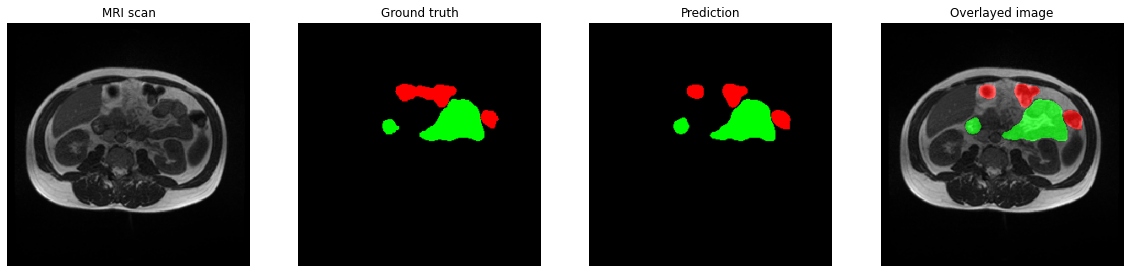

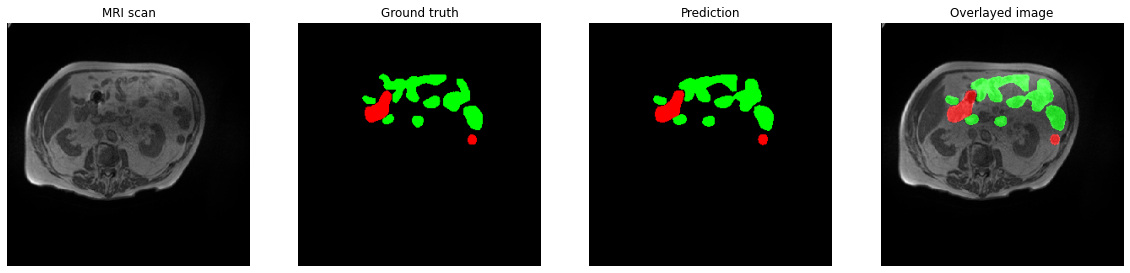

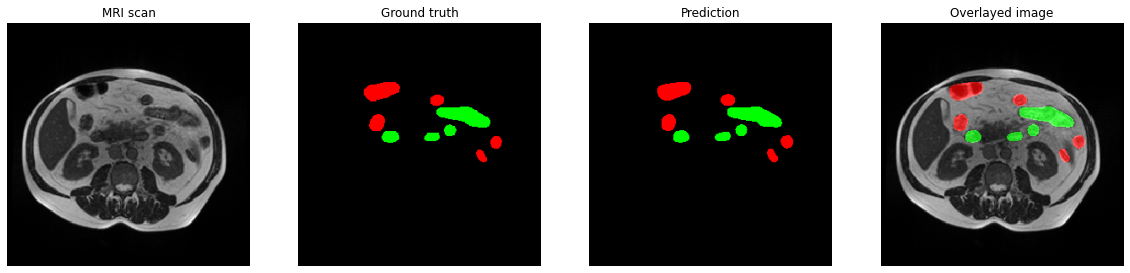

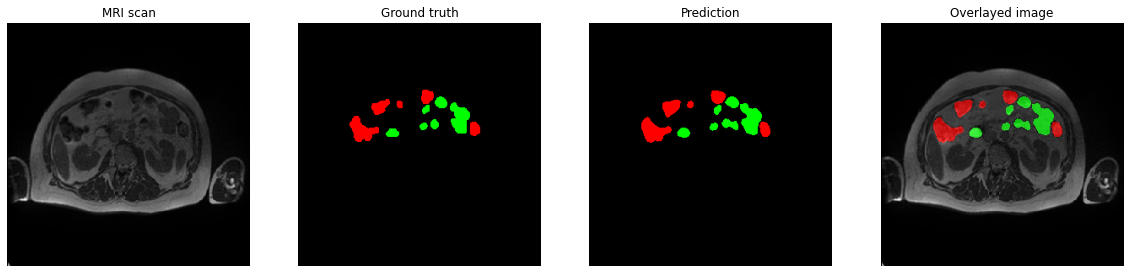

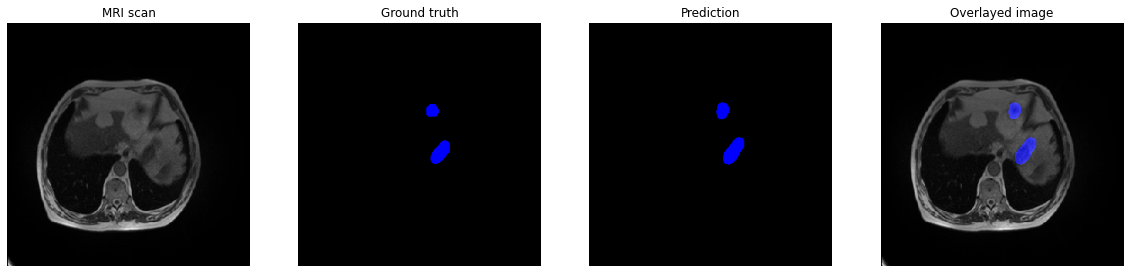

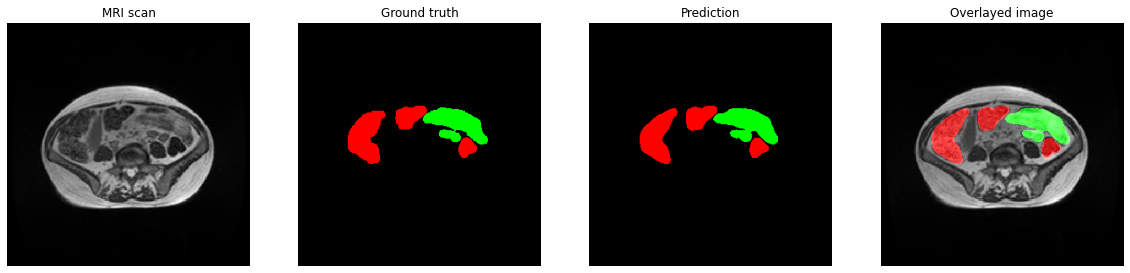

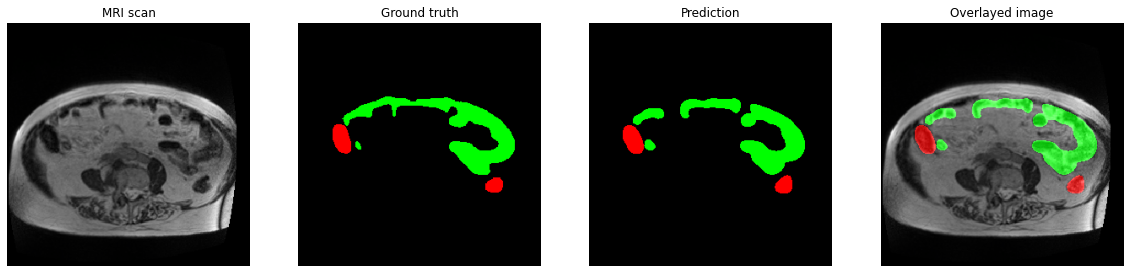

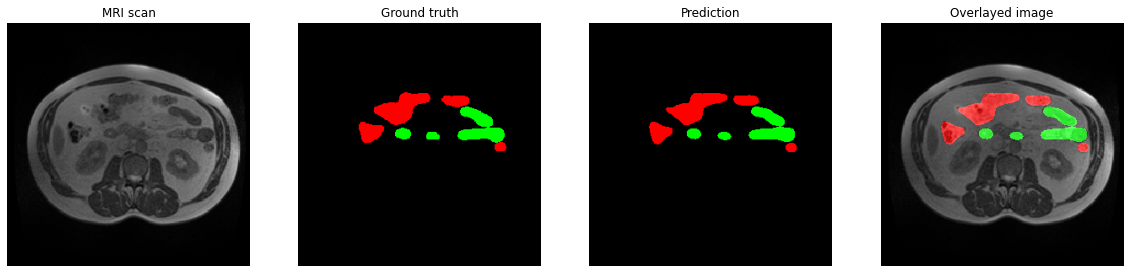

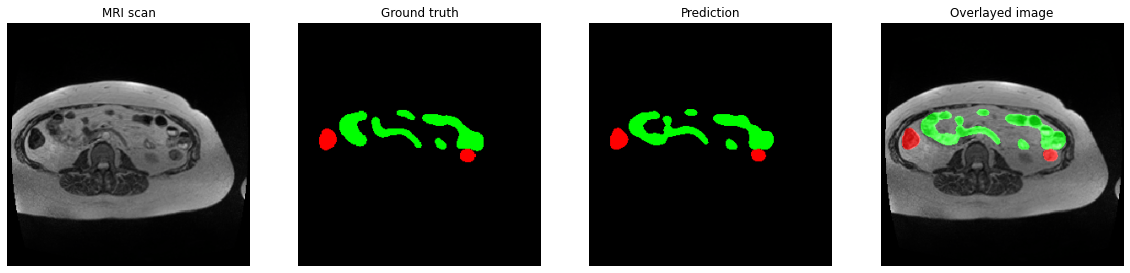

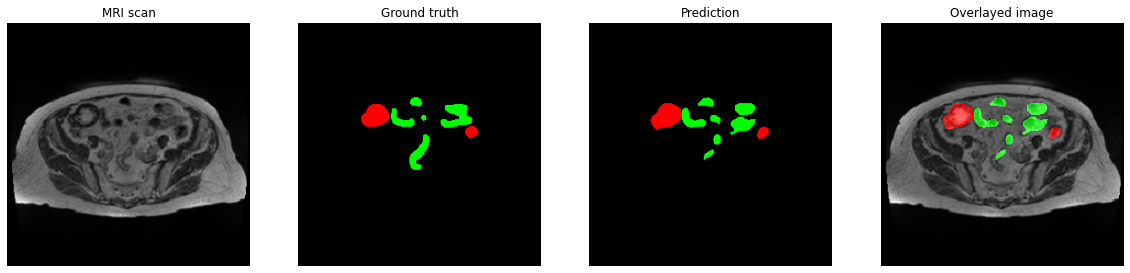

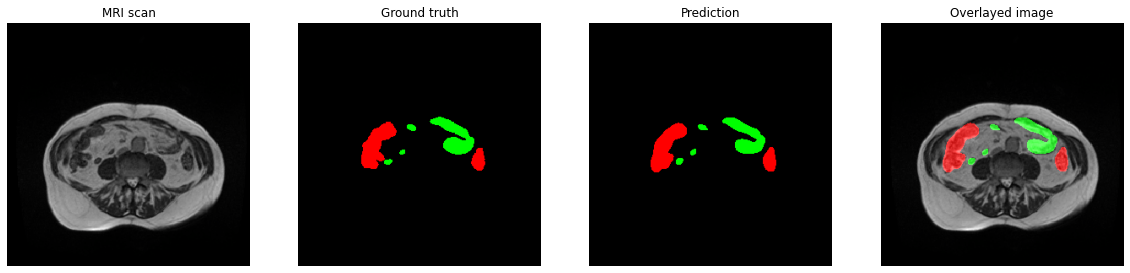

In [7]:
CKPT_PATH = '../Medical_Image_Segmentation/model_output/upernet-convnext-large_trained/ckpt_095-vloss_0.3135_vf1_0.9494.ckpt' # path for model check-pcint.
model_infer = SegmentationModel.load_from_checkpoint(CKPT_PATH)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_infer.to(DEVICE)
model_infer.eval()

inference(model_infer, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE)
